## Natural Language Autocomplete

In this notebook, we"re going to use transformers to get semantic suggestions for a given term.

In [1]:
import sys
sys.path.append("../..")
from aips import *
from aips.spark import create_view_from_collection
import pandas
import pickle
import json
import tqdm
import spacy
import numpy
from spacy.matcher import Matcher
from IPython.display import display,HTML
from aips import get_engine
from pyspark.sql import SparkSession
import sentence_transformers

engine = get_engine()
pandas.set_option("display.max_rows", 1000)
spark = SparkSession.builder.appName("AIPS").getOrCreate()

/opt/conda/lib/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/opt/conda/lib/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load and clean the Outdoors dataset

In [2]:
create_view_from_collection(engine.get_collection("outdoors"), "outdoors")
outdoors_dataframe = spark.sql("SELECT * from outdoors")
print(outdoors_dataframe.count())

18456


## Make a vocabulary of all the concepts in a corpus

In [3]:
nlp = spacy.load("en_core_web_sm")

## Listing 13.9

In [4]:
def normalize(span):
    return " ".join([token.lemma_.lower() for token in span])

def yield_tuple(dataframe, column, total):
    total = total or 100
    for idx, row in dataframe.iterrows():
        if idx < total:
            yield (row[column], idx)

def get_concepts(collection, source_field, total=None, load_from_cache=True):
    if load_from_cache:
        os.makedirs(os.path.dirname("data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
        with open("data/outdoors/outdoors_concepts.pickle","rb") as fd:
            concepts = pickle.load(fd)
        with open("data/outdoors/outdoors_labels.pickle","rb") as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print("Extracting concepts. This could take a while. Take a break and stretch :)")
    create_view_from_collection(collection, "concept_data")
    dataframe = spark.sql("SELECT * FROM concept_data")
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ["NN", "NNP", "NNS", "NOUN"] #Nouns
    verbtags = ["VB", "VBD", "VBG", "VBN",
                "VBP", "VBZ", "VERB"] #Verbs
    matcher.add("noun_phrases", [[{"TAG": {"IN": nountags},
                                   "IS_ALPHA": True,
                                   "OP": "+"}]])
    matcher.add("verb_phrases", [[{"TAG": {"IN": verbtags},
                                   "IS_ALPHA": True, "OP": "+",
                                   "LEMMA": {"NOT_IN": ["be"]}}]])
    for doc, _ in tqdm.tqdm(nlp.pipe(yield_tuple(dataframe,
                                                 source_field,
                                                 total),
                                     batch_size=40,
                                     n_threads=4,
                                     as_tuples=True),
                             total=total):
        matches = matcher(doc)
        for _, start, end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i, phrase in phrases:
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    os.makedirs(os.path.dirname("data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
    with open("data/outdoors/outdoors_concepts.pickle","wb") as fd:
        pickle.dump(sorted_concepts, fd)
    with open("data/outdoors/outdoors_labels.pickle","wb") as fd:
        pickle.dump(labels, fd)
    
    return sorted_concepts, labels

## Listing 13.10

### Examining the vocabulary

What are the concepts with the highest frequency?

In [5]:
collection = engine.get_collection("outdoors")
concepts, labels = get_concepts(collection, source_field="body",
                                load_from_cache=True)
topcons = {key: value for (key, value)
           in concepts.items() if value > 5}
print(f"Total number of labels: {len(labels.keys())}")
print(f"Total number of concepts: {len(concepts.keys())}")
print(f"Concepts with greater than 5 term frequency: {len(topcons.keys())}")
print(json.dumps(topcons, indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [6]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

## Listing 13.11

In [7]:
def get_embeddings(texts, model, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = model.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [ ]:
#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6
phrases = [key for (key, tf) in concepts.items() if tf >= minimum_frequency]
cache_name = "outdoors_embeddings"
#set ignore_cache=True to regenerate the embeddings rather than loading from the cache
embeddings = get_embeddings(phrases, transformer, cache_name,
                                          ignore_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.12

### Explore the top similarities for the top terms

In [9]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [10]:
def rank_similarities(phrases, similarities):
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(similarities) - 1):
        for b in range(a + 1, len(similarities)):
            a_phrases.append(phrases[a])
            b_phrases.append(phrases[b])
            scores.append(float(similarities[a][b]))
    dataframe = pandas.DataFrame({"score": scores,
                                  "phrase a": a_phrases, "phrase b": b_phrases})
    dataframe["idx"] = range(len(dataframe))
    dataframe = dataframe.reindex(columns=["idx", "score", "phrase a", "phrase b"])
    return dataframe.sort_values(by=["score"], ascending=False,
                                    ignore_index=True)

In [11]:
#Find the pairs with the highest cosine similarity scores
normalized_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence_transformers.util.dot_score(
    normalized_embeddings[0:250],
    normalized_embeddings[0:250])
comparisons = rank_similarities(phrases, similarities)
display(HTML(comparisons[:10].to_html(index=False)))

idx,score,phrase a,phrase b
31096,0.928151,protect,protection
13241,0.923570,climbing,climber
18096,0.878894,camp,camping
7282,0.833662,climb,climbing
10312,0.821081,something,someone
8813,0.815187,hike,hiking
4182,0.784663,people,person
7354,0.782961,climb,climber
1027,0.770643,go,leave
4422,0.768611,keep,stay


## Listing 13.13

/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


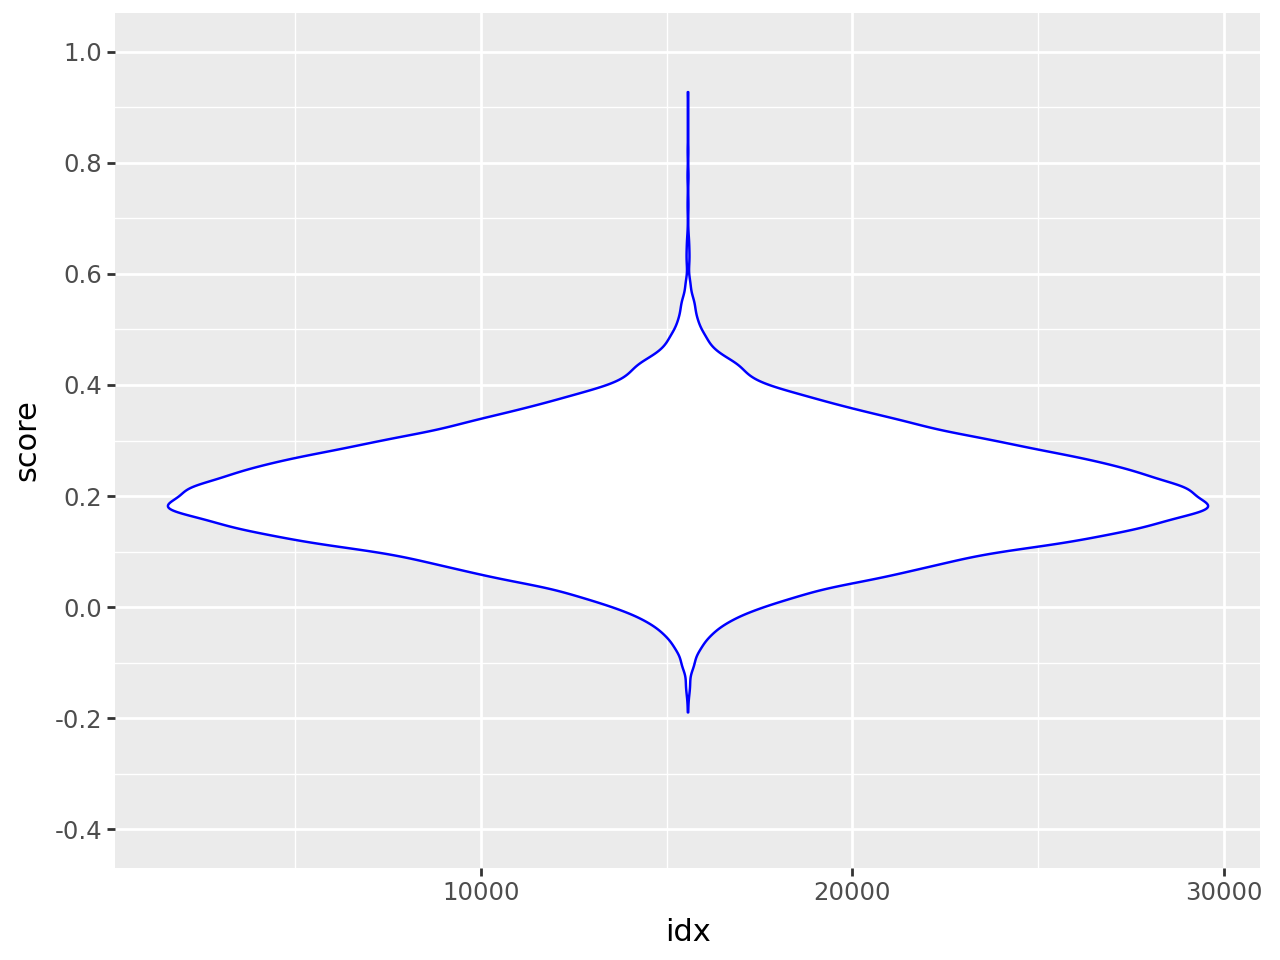

{<Figure Size: (640 x 480)>}

In [12]:
from plotnine import *
candidate_synonyms = comparisons[comparisons["score"] > 0.0]
{
    ggplot(comparisons, aes("idx", "score")) + 
    geom_violin(color="blue") +
    scale_y_continuous(limits=[-0.4, 1.0],
                       breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.14

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [13]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
concepts_index = nmslib.init(method="hnsw",
                             space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
concepts_index.addDataPointBatch(normalized_embeddings)
concepts_index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term "bag"
ids, _ = concepts_index.knnQuery(
    normalized_embeddings[25], k=10)
matches = [labels[phrases[i]].lower() for i in ids]
display(matches)

['bag',
 'bag ratings',
 'bag cover',
 'bag liner',
 'garbage bags',
 'wag bags',
 'bag cooking',
 'airbag',
 'paper bag',
 'tea bags']

## Listing 13.15

In [14]:
def print_labels(prefix,matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for (l, d) in matches:
        print(str(int(d * 1000) / 1000), "|", l)

In [15]:
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        similarity = distances[i] * -1
        if similarity >= min_similarity:
            matches.append((phrases[ids[i]], similarity))
    if not len(matches):
        matches.append((phrases[ids[1]], distances[1] * -1))
    return matches

def semantic_suggest(prefix, phrases):
    matches = embedding_search(concepts_index, prefix, phrases)
    print_labels(prefix, matches)

In [16]:
semantic_suggest("mountain hike", phrases)

1.0 | mountain hike
0.975 | mountain hiking
0.847 | mountain trail
0.787 | mountain guide
0.779 | mountain terrain
0.775 | mountain climbing
0.768 | mountain ridge
0.754 | winter hike


In [17]:
semantic_suggest("campfire", phrases)

0.999 | campfire
0.956 | camp fire
0.928 | campfire impact
0.865 | camping fuel
0.823 | camping stove
0.796 | camp stove
0.775 | cooking fire
0.774 | campground
0.764 | fireplace
0.759 | camping area
0.755 | have camp


In [18]:
semantic_suggest("dehyd", phrases)

0.941 | dehydrate
0.931 | dehydration
0.852 | rehydration
0.851 | dehydrator
0.836 | hydration
0.835 | hydrating
0.822 | rehydrate
0.812 | hydrate
0.788 | hydration pack
0.776 | hydration system


In [19]:
semantic_suggest("compa", phrases)

0.863 | comp
0.829 | compact
0.803 | compile
0.792 | compost
0.786 | compass
0.778 | competitor
0.765 | competence
0.758 | compactor
0.755 | compare


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [20]:
def build_candidate_set(cons):
    terms = list(cons.keys())
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = embedding_search(concepts_index, term, phrases=terms, k=25)
        originals += [term] * len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({"term": originals, "candidate": candidates, "score":scores})
    return pairs

In [21]:
pairs = build_candidate_set(topcons)
pairs.to_csv("pairs.csv")

100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


In [22]:
#Compare a list of terms
def compare(terms):

    term_embeddings = transformer.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms) - 1):
        for b in range(a + 1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = sentence_transformers.util.pytorch_cos_sim(
                term_embeddings[a], term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                    "score": scores, "name": "similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [23]:
#Gender-occupational bias example
#Note the similarity scores for gender and occupation 
compare(["man", "woman", "nurse practitioner", "doctor"])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Addendum: Vector Space Visualization Figure 13.6
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

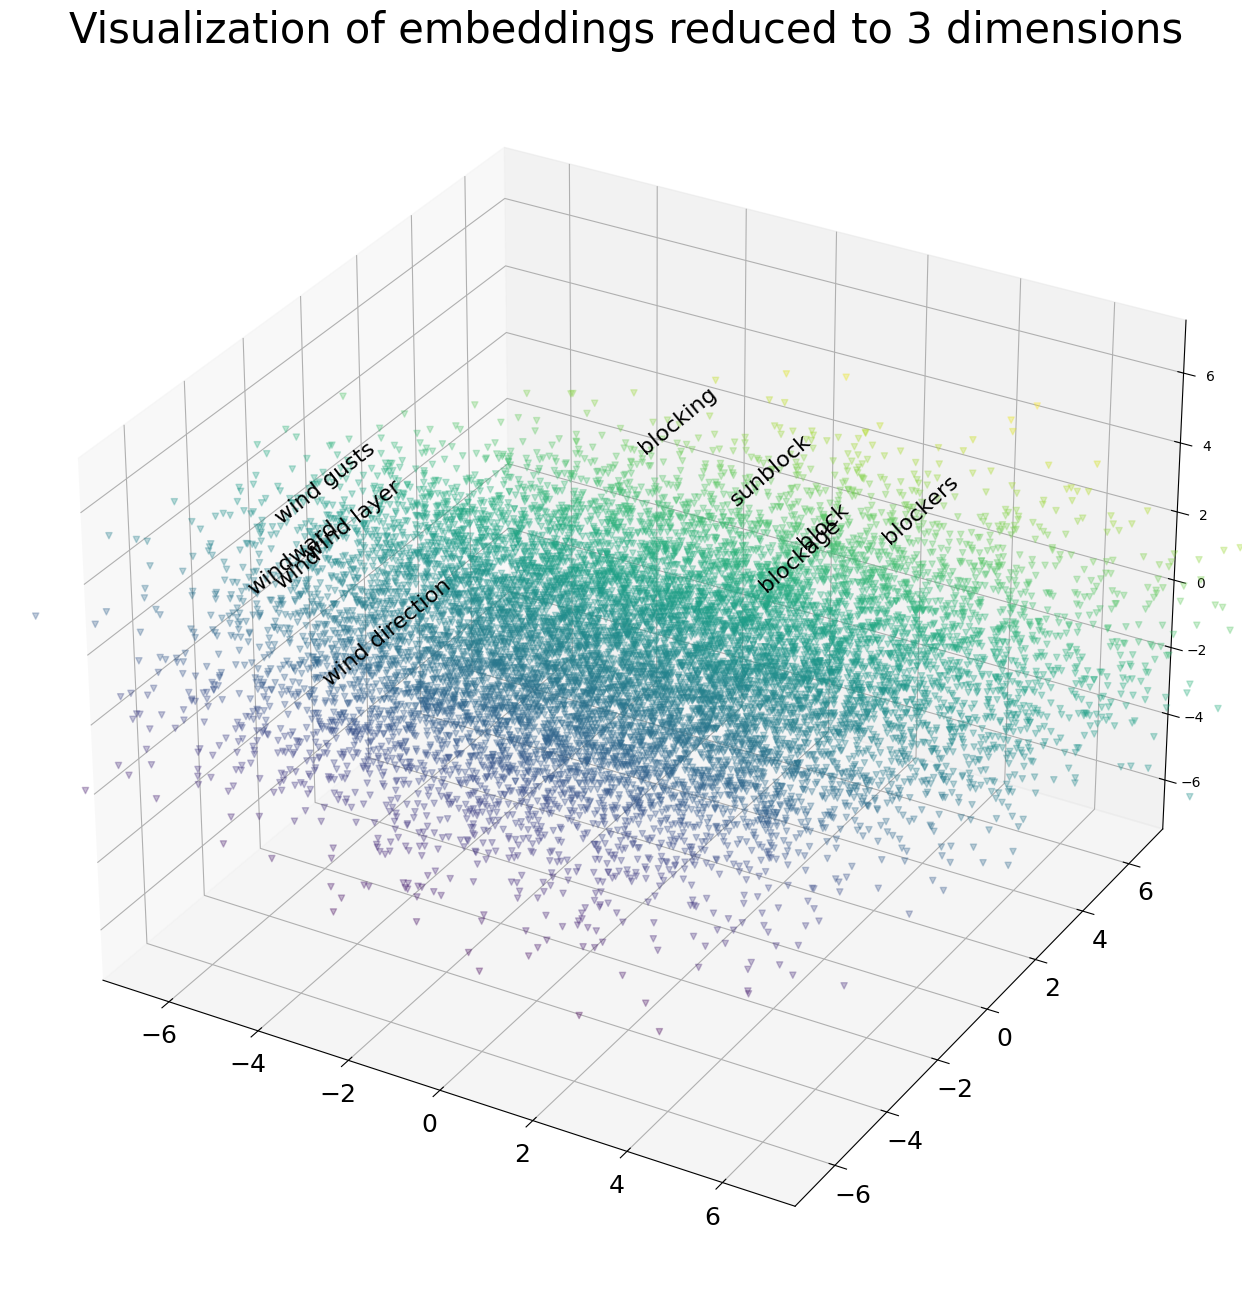

In [24]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = numpy.array(embeddings)
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = concepts_index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = concepts_index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir, fontsize=16)

ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-7.5, 7.5)
ax.set_zlim(-7.5, 7.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
ax.set_title('Visualization of embeddings reduced to 3 dimensions', fontsize=30) # increase or decrease y as needed
plt.show()

## Addendum: Find topic vector centroids with KMeans

In [25]:
from torch import stack as  torch_stack
from sklearn.cluster import KMeans

def semanticnearest(embeddings,k=20):
    matches = []
    ids, distances = concepts_index.knnQuery(embeddings, k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = distances[i] * -1
        if dist>0.6:
            matches.append((ids[i], text, dist))
    if not len(matches):
        matches.append(([ids[1]], phrases[ids[1]], dist))
    return matches

In [26]:
def findcentroids(embeddings, n_clusters=8, max_iter=300):
    centroids = []
    centroid_embeddings = []
    vectors = numpy.array(embeddings)
    kmeans = KMeans(n_clusters=n_clusters, random_state=505, max_iter=max_iter).fit(vectors)
    for centroid in kmeans.cluster_centers_:
        matches = semanticnearest(centroid,k=5)
        centroids.append(matches[0])
        centroid_embeddings.append(embeddings[matches[0][0]])
        display(HTML(f"<h4>Results for: <em> centroid {str(len(centroids)-1)}</em></h4>"))
        for i,l,d in matches:
            if l in labels.keys():
                l = labels[l].lower()
            print(str(i) + "\t" + l + "\t" + str(d))
    
    return centroids,numpy.stack(centroid_embeddings)

In [27]:
centroids, centroid_embeddings = findcentroids(embeddings, n_clusters=100,  max_iter=50)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


131	dogs	7.2022857666015625
10705	dog sled	6.981184482574463
10673	dog attacks	6.8989787101745605
96	animals	6.876914978027344
8601	dogs	6.858933448791504


1718	shotgun	10.554573059082031
742	guns	10.41041374206543
6615	gunshot	10.267881393432617
7451	shotgun shells	10.016422271728516
10150	gun season	9.789478302001953


2865	gauge	10.025125503540039
641	g	10.013925552368164
8974	gaia gps	9.726095199584961
12260	gander	9.609748840332031
7024	grog	9.473861694335938


11447	rope systems	8.531919479370117
12141	rope friction	8.061320304870605
4046	rope stretch	7.946592330932617
4719	persist	7.910519123077393
12	rope	7.8990912437438965


5619	buying	9.335536003112793
4422	buyer	8.779233932495117
685	purchasing	8.74071216583252
110	buying	8.615089416503906
7334	price tag	8.514826774597168


770	skiing	13.9109525680542
9471	ski slope	13.818439483642578
1557	skier	13.469789505004883
153	skiing	13.37520980834961
9050	at skis	13.363271713256836


6266	moisten	9.493778228759766
11909	moat	9.455949783325195
7202	moisture content	9.392165184020996
6658	moisturizer	9.33210563659668
442	moisture	9.32852840423584


2413	extension	10.187589645385742
2098	e	9.887520790100098
5884	expel	9.835673332214355
2175	exerting	9.56474494934082
10636	engraved	9.550604820251465


2667	electronics	7.695206642150879
4598	embedded	7.539338111877441
5225	conductor	7.490270614624023
10060	experience level	7.450250625610352
10404	skyline	7.434006214141846


2602	n	10.422711372375488
7539	ne	10.200584411621094
11971	nestled	9.53637409210205
4107	ny	9.534656524658203
10024	nts	9.486238479614258


7250	carbonate	9.630046844482422
785	carbon	9.449596405029297
2182	coconut	9.162172317504883
10635	coconut shell	9.153450012207031
5863	caribiners	9.063810348510742


6103	sw	11.30024242401123
493	swim	11.197742462158203
10922	swift	10.923288345336914
7221	swat	10.756401062011719
10037	swipe	10.712603569030762


2033	wilderness area	10.595847129821777
309	wilderness	10.479524612426758
9559	wilderness trip	10.037864685058594
10394	wild country	9.926726341247559
9437	wilderness permit	9.866880416870117


4712	field guides	7.926678657531738
4693	game trail	7.728925704956055
389	field	7.5030012130737305
7460	field points	7.299607276916504
10270	field test	7.148769378662109


541	hammocks	7.6510443687438965
11250	hammock systems	7.645929336547852
2241	maple	7.5087103843688965
8191	hammocking	7.25922155380249
886	mat	7.243191719055176


60	climbing	13.164630889892578
4160	climbing wall	12.839049339294434
6205	climbing grades	12.708711624145508
8884	climbing style	12.62637710571289
9219	climbing trip	12.469368934631348


898	b	9.790145874023438
11190	ba	9.470160484313965
3410	barb	9.40261173248291
4003	bacon	9.173324584960938
2916	ben	9.146051406860352


287	emergency	15.539039611816406
3850	emergency services	15.415410041809082
7038	emergency use	15.226373672485352
11129	emergency response	15.135271072387695
9775	emergency number	14.996849060058594


5206	logo	8.232940673828125
4070	ligaments	7.999628067016602
11921	sorels	7.9867753982543945
7585	lesions	7.907843112945557
1439	l	7.8085036277771


90	temperature	9.713693618774414
3460	temperature rating	9.349380493164062
3287	temperature range	9.343668937683105
11632	temperature gradients	9.3272123336792
3474	sensations	9.18455696105957


11542	dnt	9.948343276977539
1852	d	9.916374206542969
7002	delorme	9.892782211303711
4547	dent	9.86124038696289
9735	duo	9.452152252197266


2801	j	7.698341369628906
11481	jb	7.47982120513916
10358	jostled	7.2790207862854
2213	journal	7.272131443023682
4944	jerk	7.258993625640869


721	re	10.31106948852539
1396	r	9.843616485595703
4089	reps	9.77528190612793
2665	residue	9.693038940429688
12307	reserved	9.647811889648438


12055	oxygen bottles	10.0477933883667
6776	pop bottles	9.621796607971191
9303	squeeze bottle	9.461039543151855
6929	spray bottle	9.290040016174316
11133	liter bottle	9.257987022399902


5101	safety precaution	13.653963088989258
183	safety	13.625102996826172
9273	safety aspect	13.422150611877441
6378	safety measures	13.293819427490234
8949	safety system	13.178619384765625


11263	belay carabiner	9.804123878479004
1388	boar	9.76162338256836
3854	bob	9.589390754699707
6880	battery acid	9.53543472290039
7442	blob	9.444321632385254


84	mountains	13.886871337890625
11653	mountain region	13.680322647094727
5184	mountain national	13.451791763305664
6987	mountain area	13.449373245239258
7808	mountain project	13.196228981018066


7891	life expectancy	10.473711013793945
6603	retirement	10.258148193359375
4859	longevity	9.98668384552002
9586	retie	9.942484855651855
10355	outlasted	9.806347846984863


941	have done	9.69675064086914
0	have	9.597740173339844
11959	remember having	9.555819511413574
6587	seen have	9.548417091369629
881	have had	9.543234825134277


4943	erring	8.892302513122559
1396	r	8.750926971435547
4404	reeds	8.349803924560547
5457	roaring	8.083988189697266
9163	ruff	8.056299209594727


2190	tangled	8.252544403076172
8398	entangled	7.718594074249268
3692	dangling	7.6348090171813965
8726	diameter rope	7.6265058517456055
5543	friction knot	7.612905502319336


52	bears	14.806414604187012
8149	bear territory	14.101733207702637
6637	bear boxes	13.775827407836914
2144	bear country	13.716547966003418
6804	bear bangers	13.468559265136719


7849	rock type	8.67183780670166
10468	red rock	8.659748077392578
63	rock	8.598150253295898
8777	rock salt	8.447104454040527
3123	rocker	8.348098754882812


4603	explosion	9.463373184204102
4288	geography	9.45327377319336
7758	geographical region	9.348190307617188
4913	geographic	9.323238372802734
2138	erosion	9.262588500976562


7223	laurel	9.473228454589844
5528	lukla	9.23269271850586
5798	lint	8.76274299621582
8288	luke	8.746406555175781
10929	laos	8.59801959991455


205	increased	12.249340057373047
3651	enhance	11.610807418823242
2362	high	11.56481647491455
3891	succeed	11.510568618774414
6567	increments	11.343681335449219


1928	h	8.869743347167969
10503	hutte	8.322912216186523
11818	hasten	8.276845932006836
7088	hwy	8.273401260375977
4827	hace	8.255081176757812


278	north	10.715417861938477
3848	north face	10.382608413696289
9365	northface	10.334970474243164
12301	northwest face	10.134303092956543
2815	northwest	10.113344192504883


12012	underneath	8.668103218078613
758	lowering	8.641227722167969
10134	under	8.573153495788574
4901	designation	8.49024772644043
182	level	8.489255905151367


53	fire	12.590877532958984
8855	fire risk	11.675952911376953
9178	fire way	11.585872650146484
6248	stove fuel	11.452192306518555
12335	firelighter	11.447981834411621


539	f	9.455721855163574
12051	fcrf	9.207575798034668
4221	fir	8.866588592529297
7864	firn	8.802047729492188
7175	fusion	8.787567138671875


332	training	10.118282318115234
9500	training courses	9.992923736572266
8551	training program	9.954812049865723
11182	training sessions	9.831061363220215
8926	has taught	9.251701354980469


613	trouble	9.234315872192383
65	problem	9.036727905273438
8607	bear problems	8.463533401489258
3101	conflicting	8.322457313537598
242	damage	8.290670394897461


9384	sc	9.989335060119629
1112	s	9.943717956542969
8051	subsets	9.43000602722168
9077	scenic	9.418745040893555
6519	sss	9.380577087402344


4319	decompose	9.731101036071777
6516	drones	9.541143417358398
4250	drowning	9.488266944885254
6964	dwelling	9.468342781066895
1230	down	9.423816680908203


2953	sea kayak	10.442506790161133
9957	water boat	10.045516967773438
2188	sailboat	9.846017837524414
7004	fishing kayak	9.845159530639648
7082	kayak paddle	9.687015533447266


1542	consequences	10.036957740783691
1434	concentration	9.906900405883789
6763	contraction	9.775527954101562
9767	consent	9.71877384185791
10166	contraptions	9.68647575378418


1441	polyester	9.320025444030762
10847	penknife	9.313180923461914
4355	polypro	9.210691452026367
32	point	9.15964126586914
2549	penetrates	9.101781845092773


542	mm	9.363067626953125
257	m	9.286470413208008
6851	multi	8.812043190002441
949	mass	8.716011047363281
1528	mid	8.423519134521484


46	food	11.063397407531738
10547	food preparation	10.941784858703613
7376	food items	10.809882164001465
8240	food prep	10.547788619995117
11722	food pack	10.515373229980469


7036	fl	10.165380477905273
1738	flares	9.854691505432129
7175	fusion	9.25985336303711
2361	flavors	9.092466354370117
9636	flatness	9.082320213317871


2079	has got	10.233407974243164
8061	try getting	10.162503242492676
3	getting	10.021724700927734
6860	go getting	9.933597564697266
7650	suggest getting	9.786581993103027


866	considerations	9.831985473632812
6446	reconsider	9.465237617492676
92	considering	9.347208976745605
4080	interpretations	9.3399019241333
5079	speculation	8.998054504394531


3471	concealed	8.737906455993652
9994	caverns	8.69708251953125
5081	cocoon	8.68966007232666
8088	crocs	8.509124755859375
10399	coconino	8.503806114196777


11134	ssp	8.930110931396484
4601	spores	8.731584548950195
1538	spine	8.727005004882812
3987	spices	8.68503189086914
10508	sep	8.630929946899414


6570	walking shoes	10.772924423217773
4594	walking boots	10.523372650146484
3154	footpath	10.479981422424316
30	feet	10.467926025390625
6397	footsteps	10.333292007446289


10456	nice	11.336793899536133
3099	cleaner	11.12735652923584
369	clean	11.111581802368164
1513	ease	10.689393997192383
1261	clear	10.642157554626465


9803	do keep	10.088134765625
1988	withstands	9.842984199523926
126	avoid	9.741963386535645
11390	does stay	9.684379577636719
5366	have keeping	9.65300178527832


2856	alberta	6.925067901611328
1954	assist	6.894822120666504
3763	ass	6.86730432510376
6679	atlas	6.833508491516113
11340	assateague	6.818901538848877


2722	evolved	11.39335823059082
1336	differ	11.257881164550781
6076	relocation	11.228973388671875
3698	differentiates	11.015663146972656
6899	diffuse	10.656407356262207


6684	trail system	11.086424827575684
8176	trails	10.623127937316895
6527	trail map	10.588077545166016
28	trail	10.540056228637695
11621	trailing	10.332483291625977


3360	cellphone	13.39687728881836
377	phone	13.334861755371094
5537	telephone	13.294722557067871
1747	cell phone	13.275378227233887
6789	cell phone coverage	13.201822280883789


285	rest	11.63571834564209
11333	resting	11.593923568725586
5319	ve slept	11.37234115600586
10115	sleeping area	11.249914169311523
2313	retreating	11.139753341674805


3958	blanc	9.462766647338867
7871	blake	8.71519660949707
9112	blasting	8.693490028381348
8988	bloqueurs	8.473636627197266
3538	breast	8.378552436828613


10466	handwashing	10.043990135192871
11868	dishwashing	9.99398422241211
7146	scrubbing	9.783943176269531
1514	wipes	9.738744735717773
10465	rinsing	9.734768867492676


12093	national park system	11.43934440612793
622	national park	11.319283485412598
114	park	11.244245529174805
11594	park area	11.12055778503418
2172	national park service	11.041875839233398


262	c	9.516639709472656
3171	cdc	9.170555114746094
2204	carcass	8.874223709106445
1377	calculate	8.678567886352539
6268	camber	8.630973815917969


2913	digest	9.538362503051758
3621	digestion	9.502500534057617
683	dig	8.878657341003418
8058	ingestion	8.682872772216797
7144	digging	8.323848724365234


9204	rubble	10.60948657989502
691	rubber	10.433411598205566
1615	bubbles	9.770305633544922
4792	rubbish	9.756078720092773
4728	ribbon	9.402986526489258


4103	insight	10.797548294067383
9587	viewer	10.605655670166016
5620	viewing	10.555787086486816
7240	eyesight	10.201614379882812
553	view	10.027345657348633


2245	w	9.948518753051758
11220	wy	9.634571075439453
12166	wren	9.633058547973633
802	west	9.627592086791992
5826	wa	9.53022575378418


2660	dispersed	12.895135879516602
3344	displaced	12.81641960144043
1750	get rid	12.80908203125
7969	withdrawal	12.789697647094727
5593	disregard	12.743924140930176


1402	v	10.519464492797852
5870	va	10.516252517700195
1502	valve	10.311352729797363
2139	van	10.076641082763672
704	uv	10.075418472290039


12086	transducers	10.660405158996582
2970	transmission	10.288772583007812
2056	translate	9.952664375305176
3659	elevation changes	9.929598808288574
5268	flotation device	9.866743087768555


3472	k	9.411072731018066
7389	ken	8.773681640625
11750	karen	8.439525604248047
10048	kso	8.325143814086914
2321	kerosene	8.324384689331055


11079	survival scenario	13.036870956420898
1498	survival situation	12.920745849609375
6385	survivalist	12.881462097167969
365	survival	12.779831886291504
9183	survival techniques	12.533843994140625


11900	rt	7.70419979095459
4821	tract	7.53541898727417
6730	tribes	7.49711799621582
1722	trousers	7.4969282150268555
9696	trapezoid	7.478792190551758


1128	t	10.665961265563965
8745	tent design	10.545835494995117
24	tent	10.518589973449707
8683	tent material	10.488451957702637
11022	tso	10.376843452453613


11720	meetup	9.583075523376465
615	meet	9.338065147399902
2550	organize	9.182624816894531
7582	has gathered	9.060613632202148
3274	assemble	8.941858291625977


41	start	13.273859977722168
4157	have started	13.052828788757324
4170	get started	13.048385620117188
578	begins	12.957664489746094
1574	beginning	12.837368965148926


1109	sunlight	12.391868591308594
11942	sun light	12.189827919006348
5056	sunshine	12.07876968383789
9592	sun exposure	12.011878967285156
305	sun	11.953448295593262


5	water	13.832381248474121
7458	water systems	13.799169540405273
9093	watering	13.742568969726562
6294	water flow	13.349416732788086
8322	water filtration	13.294500350952148


2248	york	10.337480545043945
1909	y	10.183904647827148
9145	york state	10.109270095825195
10972	york city	9.901330947875977
2381	new york	9.674809455871582


9900	pipistrelle	9.441423416137695
10575	pooping	9.16118049621582
8932	pus	9.07059097290039
8382	prepping	9.046018600463867
5761	pp	9.03300952911377


408	plastic	8.139121055603027
11076	plastic sheet	8.031190872192383
4364	physiology	7.692321300506592
4578	peroxide	7.68328857421875
8282	metal frame	7.628844261169434


5277	overloading	10.303791046142578
7231	load bearing	9.557626724243164
209	load	9.524031639099121
10410	carrying capacity	9.514552116394043
5617	overuse	9.208651542663574


1701	hiking trails	13.280274391174316
11587	hiking paths	13.132631301879883
93	hiking	12.868415832519531
3025	hiking trip	12.842010498046875
8955	hiking routes	12.796712875366211


5610	camping area	15.190397262573242
4416	camping sites	15.111692428588867
101	camping	15.093730926513672
10206	camping place	15.081089973449707
4735	camping spot	14.929734230041504


7828	air force	10.865848541259766
3081	aircrafts	10.842029571533203
2723	airplanes	10.71068000793457
95	air	10.691518783569336
8746	air exchange	10.64330005645752


3103	arrangement	9.732755661010742
7662	signifies	9.424543380737305
4958	enclosure	9.127312660217285
4281	assigned	9.091205596923828
430	according	9.066680908203125


59	snow	11.469074249267578
2083	freezing	11.459646224975586
9459	snow level	11.356040954589844
8369	icefall	11.33867359161377
135	winter	11.184364318847656


6972	gadget	9.470022201538086
10019	geotags	9.370455741882324
1517	garbage	9.288829803466797
10932	geotagged	9.280435562133789
10020	geotagging	9.207847595214844


9864	body types	15.137996673583984
54	body	15.024591445922852
5759	body position	14.931318283081055
7407	body temp	14.880575180053711
7005	body mass	14.803720474243164


8199	rescue situations	11.610692977905273
9058	rescue work	11.48339557647705
255	rescue	11.479592323303223
6552	rescue techniques	10.98760986328125
4987	rescue service	10.957934379577637


5292	compact	8.695096969604492
7413	clutch	8.52945327758789
9451	ch	8.507346153259277
1081	compress	8.348377227783203
10502	compactor	8.342792510986328


61	tree	11.266782760620117
4487	tree branches	11.26427173614502
9226	tree cover	11.119697570800781
9533	trees limbs	11.010275840759277
12089	tree stumps	10.988395690917969


1997	weather conditions	11.689956665039062
10245	weathering	11.55788803100586
2697	weather forecast	11.440242767333984
109	weather	11.413013458251953
6840	weather reports	11.348491668701172


10921	proper	9.751601219177246
8285	prevalence	9.372764587402344
2585	propose	9.3640718460083
2983	p	9.196404457092285
8382	prepping	8.951501846313477


1880	in	8.36552619934082
4715	initiate	8.17536449432373
2183	ii	7.977560997009277
3801	ie	7.850099086761475
4190	id	7.800360202789307


6371	inhabitants	9.827348709106445
187	couple	9.52784252166748
2606	relationship	9.188905715942383
760	partner	8.994865417480469
4838	couple years	8.967008590698242


In [28]:
print(centroids)
print(centroid_embeddings)

[(131, 'dog', 7.2022857666015625), (1718, 'shotgun', 10.554573059082031), (2865, 'gauge', 10.025125503540039), (11447, 'rope system', 8.531919479370117), (5619, 'buying', 9.335536003112793), (770, 'skiing', 13.9109525680542), (6266, 'moisten', 9.493778228759766), (2413, 'extension', 10.187589645385742), (2667, 'electronic', 7.695206642150879), (2602, 'n', 10.422711372375488), (7250, 'carbonate', 9.630046844482422), (6103, 'sw', 11.30024242401123), (2033, 'wilderness area', 10.595847129821777), (4712, 'field guide', 7.926678657531738), (541, 'hammock', 7.6510443687438965), (60, 'climbing', 13.164630889892578), (898, 'b', 9.790145874023438), (287, 'emergency', 15.539039611816406), (5206, 'logo', 8.232940673828125), (90, 'temperature', 9.713693618774414), (11542, 'dnt', 9.948343276977539), (2801, 'j', 7.698341369628906), (721, 're', 10.31106948852539), (12055, 'oxygen bottle', 10.0477933883667), (5101, 'safety precaution', 13.653963088989258), (11263, 'belay carabiner', 9.804123878479004)

In [29]:
print(centroids[0][1])

dog


In [30]:
normalized_centroid_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence_transformers.util.dot_score(normalized_centroid_embeddings, normalized_centroid_embeddings)
print("The shape of the resulting similarities:", similarities.shape)

The shape of the resulting similarities: torch.Size([12375, 12375])


Up next: [Semantic Search with Dense Vector Embeddings](4.semantic-search.ipynb)